In [10]:
import torch
from torch import nn
from einops import repeat
from einops.layers.torch import Rearrange
import numpy as np
import torch
from torch import nn, einsum
from einops import rearrange


In [11]:
class SepConv2d(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,):
        super(SepConv2d, self).__init__()
        self.depthwise = torch.nn.Conv2d(in_channels,
                                         in_channels,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         padding=padding,
                                         dilation=dilation,
                                         groups=in_channels)
        self.bn = torch.nn.BatchNorm2d(in_channels)
        self.pointwise = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x

In [12]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
    
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [13]:
class ConvAttention(nn.Module):
    def __init__(self, dim, img_size, heads = 8, dim_head = 64, kernel_size=3, q_stride=1, k_stride=1, v_stride=1, dropout = 0.,
                 last_stage=False):

        super().__init__()
        self.last_stage = last_stage
        self.img_size = img_size
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5
        pad = (kernel_size - q_stride)//2
        self.to_q = SepConv2d(dim, inner_dim, kernel_size, q_stride, pad)
        self.to_k = SepConv2d(dim, inner_dim, kernel_size, k_stride, pad)
        self.to_v = SepConv2d(dim, inner_dim, kernel_size, v_stride, pad)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        if self.last_stage:
            cls_token = x[:, 0]
            x = x[:, 1:]
            cls_token = rearrange(cls_token.unsqueeze(1), 'b n (h d) -> b h n d', h = h)
        x = rearrange(x, 'b (l w) n -> b n l w', l=self.img_size, w=self.img_size)
        q = self.to_q(x)
        q = rearrange(q, 'b (h d) l w -> b h (l w) d', h=h)

        v = self.to_v(x)
        v = rearrange(v, 'b (h d) l w -> b h (l w) d', h=h)

        k = self.to_k(x)
        k = rearrange(k, 'b (h d) l w -> b h (l w) d', h=h)

        if self.last_stage:
            q = torch.cat((cls_token, q), dim=2)
            v = torch.cat((cls_token, v), dim=2)
            k = torch.cat((cls_token, k), dim=2)


        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [14]:
class Transformer(nn.Module):
    def __init__(self, dim, img_size, depth, heads, dim_head, mlp_dim, dropout=0., last_stage=False):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, ConvAttention(dim, img_size, heads=heads, dim_head=dim_head, dropout=dropout, last_stage=last_stage)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [15]:
class CvT(nn.Module):
    def __init__(self, image_size, in_channels, num_classes, dim=64, kernels=[7, 3, 3], strides=[4, 2, 2],
                 heads=[1, 3, 6] , depth = [1, 2, 10], pool='cls', dropout=0., emb_dropout=0., scale_dim=4):
        super().__init__()


        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.pool = pool
        self.dim = dim

        ##### Stage 1 #######
        self.stage1_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[0], strides[0], 2),
            Rearrange('b c h w -> b (h w) c', h = image_size//4, w = image_size//4),
            nn.LayerNorm(dim)
        )
        self.stage1_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//4,depth=depth[0], heads=heads[0], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout),
            Rearrange('b (h w) c -> b c h w', h = image_size//4, w = image_size//4)
        )

        ##### Stage 2 #######
        in_channels = dim
        scale = heads[1]//heads[0]
        dim = scale*dim
        self.stage2_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[1], strides[1], 1),
            Rearrange('b c h w -> b (h w) c', h = image_size//8, w = image_size//8),
            nn.LayerNorm(dim)
        )
        self.stage2_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//8, depth=depth[1], heads=heads[1], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout),
            Rearrange('b (h w) c -> b c h w', h = image_size//8, w = image_size//8)
        )

        ##### Stage 3 #######
        in_channels = dim
        scale = heads[2] // heads[1]
        dim = scale * dim
        self.stage3_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[2], strides[2], 1),
            Rearrange('b c h w -> b (h w) c', h = image_size//16, w = image_size//16),
            nn.LayerNorm(dim)
        )
        self.stage3_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//16, depth=depth[2], heads=heads[2], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout, last_stage=True),
        )


        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout_large = nn.Dropout(emb_dropout)


        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):

        xs = self.stage1_conv_embed(img)
        xs = self.stage1_transformer(xs)

        xs = self.stage2_conv_embed(xs)
        xs = self.stage2_transformer(xs)

        xs = self.stage3_conv_embed(xs)
        b, n, _ = xs.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        xs = torch.cat((cls_tokens, xs), dim=1)
        xs = self.stage3_transformer(xs)
        xs = xs.mean(dim=1) if self.pool == 'mean' else xs[:, 0]

        xs = self.mlp_head(xs)
        return xs

In [8]:
img = torch.ones([1, 3, 224, 224])

model = CvT(224, 3, 1000)

model.train()

parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)

out = model(img)

print("Shape of out :", out.shape)  # [B, num_classes]

Trainable Parameters: 20.006M
Shape of out : torch.Size([1, 1000])


In [16]:
import random
import os
from math import floor
import shutil

# Set the seed for reproducibility
random.seed(42)

# Define paths
dataset_dir = r'C:\Users\USER\Documents\Kuliah\CompVis\Dataset'  # Path to your dataset folder
output_dir = r'C:\Users\USER\Documents\Kuliah\CompVis\Splitted ViT Data'    # Path where train, valid, and test folders will be created

# Classes inside the dataset folder
class_names = ['Front', 'Left Tilt', 'Right Tilt', 'Duck']

# Define split ratios
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

# Create output directories for train, valid, and test
train_dir = os.path.join(output_dir, 'train')
valid_dir = os.path.join(output_dir, 'valid')
test_dir = os.path.join(output_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split the dataset
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)  # Shuffle the data

    # Calculate split sizes
    train_size = floor(len(images) * train_ratio)
    valid_size = floor(len(images) * valid_ratio)

    # Create class directories for each split
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Split images into train, valid, and test
    train_images = images[:train_size]
    valid_images = images[train_size:train_size + valid_size]
    test_images = images[train_size + valid_size:]

    # Copy the files to the respective directories
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copyfile(src, dst)

    for img in valid_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(valid_dir, class_name, img)
        shutil.copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, class_name, img)
        shutil.copyfile(src, dst)

    print(f"Class '{class_name}': {len(train_images)} train, {len(valid_images)} valid, {len(test_images)} test")

print("Dataset successfully split!")

Class 'Front': 707 train, 202 valid, 102 test
Class 'Left Tilt': 606 train, 173 valid, 88 test
Class 'Right Tilt': 725 train, 207 valid, 105 test
Class 'Duck': 568 train, 162 valid, 82 test
Dataset successfully split!


In [17]:
from torchvision import datasets, transforms, models

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),  # This step requires NumPy to be available
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [18]:
from torch.utils.data import DataLoader

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
model = CvT(224, 3, 4)

In [20]:
from torch import nn, optim
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Assuming `optimizer` is already defined
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [21]:
# Early stopping parameters
early_stopping_patience = 5
best_val_loss = np.inf
patience_counter = 0

In [22]:
# Setup the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model.to(device)

CvT(
  (stage1_conv_embed): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
    (1): Rearrange('b c h w -> b (h w) c', h=56, w=56)
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (stage1_transformer): Sequential(
    (0): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (fn): ConvAttention(
              (to_q): SepConv2d(
                (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (to_k): SepConv2d(
                (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
                (bn): BatchNorm2d(64, eps=1e-05, 

In [23]:
# Training function with epoch indication and learning rate reduction
def train_model(model, train_loader, valid_loader, loss_fn, optimizer, epochs, device, early_stopping_patience, scheduler):
    train_loss_history, valid_loss_history = [], []
    train_acc_history, valid_acc_history = [], []

    best_val_loss = float('inf')  # Initialize best_val_loss for early stopping
    patience_counter = 0  # Initialize patience counter for early stopping

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")  # Print the current epoch

        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += labels.size(0)

            # Optionally, show progress for each batch within the epoch
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}/{len(train_loader)} processed...")

        # Calculate train loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions.double() / total_predictions

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        correct_val_predictions = 0
        total_val_predictions = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                running_val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val_predictions += torch.sum(preds == labels.data)
                total_val_predictions += labels.size(0)

        val_loss = running_val_loss / len(valid_loader.dataset)
        val_acc = correct_val_predictions.double() / total_val_predictions

        valid_loss_history.append(val_loss)
        valid_acc_history.append(val_acc.item())

        # Print epoch result
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Step the scheduler
        scheduler.step(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered!")
                break

    return train_loss_history, valid_loss_history, train_acc_history, valid_acc_history

In [24]:
# Train the model
train_loss, valid_loss, train_acc, valid_acc = train_model(model, train_loader, valid_loader, loss_fn, optimizer, epochs=50, device=device, early_stopping_patience=early_stopping_patience, scheduler=scheduler)

Epoch 1/50
Batch 0/82 processed...
Batch 10/82 processed...
Batch 20/82 processed...
Batch 30/82 processed...
Batch 40/82 processed...
Batch 50/82 processed...
Batch 60/82 processed...
Batch 70/82 processed...
Batch 80/82 processed...
Epoch 1/50 - Train Loss: 1.3781, Train Acc: 0.3580, Val Loss: 1.0176, Val Acc: 0.5874
Epoch 2/50
Batch 0/82 processed...
Batch 10/82 processed...
Batch 20/82 processed...
Batch 30/82 processed...
Batch 40/82 processed...
Batch 50/82 processed...
Batch 60/82 processed...
Batch 70/82 processed...
Batch 80/82 processed...
Epoch 2/50 - Train Loss: 0.5033, Train Acc: 0.8127, Val Loss: 0.3075, Val Acc: 0.8938
Epoch 3/50
Batch 0/82 processed...
Batch 10/82 processed...
Batch 20/82 processed...
Batch 30/82 processed...
Batch 40/82 processed...
Batch 50/82 processed...
Batch 60/82 processed...
Batch 70/82 processed...
Batch 80/82 processed...
Epoch 3/50 - Train Loss: 0.2018, Train Acc: 0.9229, Val Loss: 0.1813, Val Acc: 0.9341
Epoch 4/50
Batch 0/82 processed...
Ba

In [25]:
# Load the best model for evaluation
model.load_state_dict(torch.load('best_model_CvT.pth'))
model.eval()

C:\Users\USER\AppData\Local\Temp\ipykernel_26956\3841251095.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


CvT(
  (stage1_conv_embed): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
    (1): Rearrange('b c h w -> b (h w) c', h=56, w=56)
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (stage1_transformer): Sequential(
    (0): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (fn): ConvAttention(
              (to_q): SepConv2d(
                (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (to_k): SepConv2d(
                (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
                (bn): BatchNorm2d(64, eps=1e-05, 

In [26]:
# Tambahkan fungsi untuk menampilkan jumlah parameter dengan format yang rapi
def model_summary_custom(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    # Format output seperti gambar
    print("Total params: {:,} ({:.2f} MB)".format(total_params, total_params * 4 / (1024 ** 2)))
    print("Trainable params: {:,} ({:.2f} MB)".format(trainable_params, trainable_params * 4 / (1024 ** 2)))
    print("Non-trainable params: {:,} ({:.2f} KB)".format(non_trainable_params, non_trainable_params * 4 / 1024))

# Tampilkan ringkasan parameter model
model_summary_custom(model)

Total params: 19,622,724 (74.85 MB)
Trainable params: 19,622,724 (74.85 MB)
Non-trainable params: 0 (0.00 KB)


In [27]:
# Evaluate on the test set
def evaluate_model(model, test_loader, device):
    all_preds = []
    all_labels = []
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [28]:
from sklearn.metrics import average_precision_score

def calculate_map(y_true, y_pred, class_names):
    # Convert labels to one-hot encoding
    y_true_one_hot = np.eye(len(class_names))[y_true]
    
    # Calculate average precision for each class
    average_precisions = []
    for i in range(len(class_names)):
        average_precision = average_precision_score(y_true_one_hot[:, i], y_pred[:, i])
        average_precisions.append(average_precision)
    
    # Calculate mean average precision
    mean_average_precision = np.mean(average_precisions)
    return mean_average_precision

# Assuming y_pred contains the raw output scores from the model
with torch.no_grad():
    y_pred_scores = []
    y_true_labels = []
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        y_pred_scores.extend(outputs.cpu().numpy())
        y_true_labels.extend(labels.cpu().numpy())

y_pred_scores = np.array(y_pred_scores)
y_true_labels = np.array(y_true_labels)

# Calculate mAP
map_score = calculate_map(y_true_labels, y_pred_scores, class_names)
print(f"Mean Average Precision (mAP): {map_score:.4f}")

Mean Average Precision (mAP): 0.9871


In [29]:
# Get predictions and labels for the test set
y_pred, y_true = evaluate_model(model, test_loader, device)

In [30]:
import matplotlib.pyplot as plt

# Plot training and validation loss/accuracy
def plot_training_results(train_loss, valid_loss, train_acc, valid_acc):
    epochs_range = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Train Loss')
    plt.plot(epochs_range, valid_loss, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, label='Train Accuracy')
    plt.plot(epochs_range, valid_acc, label='Valid Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.show()

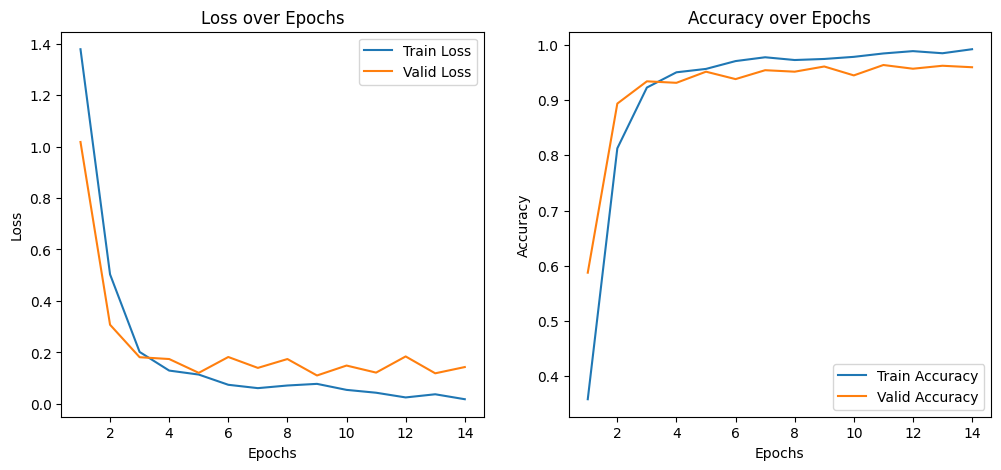

In [31]:
# Plot the training results
plot_training_results(train_loss, valid_loss, train_acc, valid_acc)

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score (macro and per-class)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-Score (macro): {f1:.4f}")

# For per-class precision, recall, and F1-score:
precision_per_class = precision_score(all_labels, all_preds, average=None)
recall_per_class = recall_score(all_labels, all_preds, average=None)
f1_per_class = f1_score(all_labels, all_preds, average=None)

for idx, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision_per_class[idx]:.4f}")
    print(f"  Recall: {recall_per_class[idx]:.4f}")
    print(f"  F1-Score: {f1_per_class[idx]:.4f}")

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.9655
Precision (macro): 0.9654
Recall (macro): 0.9653
F1-Score (macro): 0.9648
Class: Front
  Precision: 0.9747
  Recall: 0.9390
  F1-Score: 0.9565
Class: Left Tilt
  Precision: 0.9796
  Recall: 0.9412
  F1-Score: 0.9600
Class: Right Tilt
  Precision: 0.9263
  Recall: 1.0000
  F1-Score: 0.9617
Class: Duck
  Precision: 0.9810
  Recall: 0.9810
  F1-Score: 0.9810


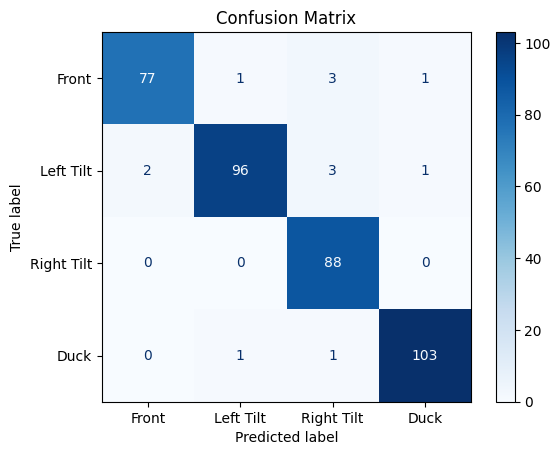

In [33]:
# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

Randomly selected image: C:\Users\USER\Documents\Kuliah\CompVis\Splitted ViT Data\test\Duck\20230629_111935_jpg.rf.7873a356499e688e7f1b55aaa2095d4c.jpg


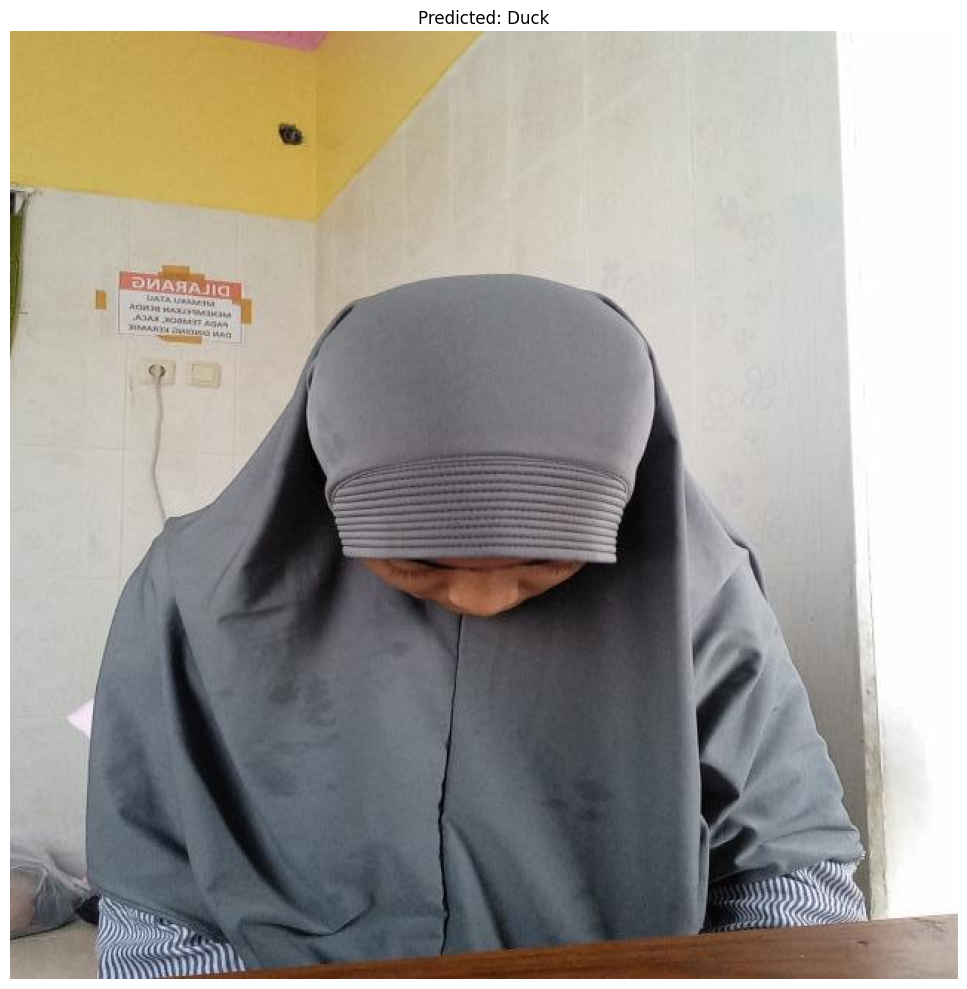

CPU times: total: 219 ms
Wall time: 355 ms


In [37]:
%%time
from PIL import Image

# Define the test folder path
testFolderPath = r'C:\Users\USER\Documents\Kuliah\CompVis\Splitted ViT Data\test'

# Ensure the folder exists
assert os.path.exists(testFolderPath), f"Folder not found at {testFolderPath}"

# Recursively get a list of all image files in the test folder (including subdirectories)
imageFiles = []
for root, dirs, files in os.walk(testFolderPath):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            imageFiles.append(os.path.join(root, file))

# Ensure there are images in the folder
assert len(imageFiles) > 0, f"No image files found in the folder {testFolderPath}"

# Randomly pick an image
randomImagePath = random.choice(imageFiles)

# Debugging: Print the randomly selected image path
print(f"Randomly selected image: {randomImagePath}")

# Load and preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of your model
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet standards
])

# Open the image using PIL and apply the preprocessing
image = Image.open(randomImagePath)
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)

# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# Perform the prediction
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_class = torch.max(output, 1)

# Define your class names
class_names = ['Duck', 'Front', 'Left Tilt', 'Right Tilt']

# Get the predicted class
predicted_label = class_names[predicted_class.item()]

# Display the image with predicted label
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(image)
ax.set_title(f"Predicted: {predicted_label}")
ax.axis('off')

plt.tight_layout()
plt.show()